In [ ]:
!pip install ultralytics kaggle kagglehub

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from IPython.display import display, Image as IPImage
from google.colab import drive
import kagglehub
from ultralytics import YOLO
import glob
import random
import shutil
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm

In [ ]:
drive.mount('/content/drive')

In [ ]:
!mkdir -p /content/helmet_dataset
os.chdir('/content/helmet_dataset')

In [ ]:
from google.colab import files
uploaded = files.upload()  # to upload kaggle.json to enable dataset import

In [ ]:
# setup kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# load the kaggle dataset
!kaggle datasets download -d andrewmvd/helmet-detection
!unzip helmet-detection.zip

In [ ]:
# directory to store dataset in YOLO format
!rm -rf /content/helmet_dataset_yolo
!mkdir -p /content/helmet_dataset_yolo/images/train /content/helmet_dataset_yolo/images/val
!mkdir -p /content/helmet_dataset_yolo/labels/train /content/helmet_dataset_yolo/labels/val

In [ ]:
# convert VOC format of dataset to YOLO-compatible format
def convert_voc_to_yolo(xml_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    result = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text

        class_name = class_name.strip().lower()
        class_id = 1 if class_name == "without helmet" else 0

        bbox = obj.find('bndbox')

        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))

        # convert to YOLO format
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        result.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return result

In [ ]:
def prepare_yolo_dataset():
    xml_files = glob.glob('/content/helmet_dataset/annotations/*.xml')
    random.shuffle(xml_files)

    # split dataset
    train_size = int(len(xml_files) * 0.8)
    train_files = xml_files[:train_size]
    val_files = xml_files[train_size:]

    # training data
    for xml_file in tqdm(train_files, desc="Training Data"):
        base_name = os.path.basename(xml_file).replace('.xml', '')
        img_file = f'/content/helmet_dataset/images/{base_name}.png'

        if not os.path.exists(img_file):
            continue

        img = cv2.imread(img_file)
        h, w = img.shape[:2]

        yolo_annotations = convert_voc_to_yolo(xml_file, w, h)
        if not yolo_annotations:
            continue

        # save files
        shutil.copy(img_file, f'/content/helmet_dataset_yolo/images/train/{base_name}.png')
        label_path = f'/content/helmet_dataset_yolo/labels/train/{base_name}.txt'

        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

    # validation data
    for xml_file in tqdm(val_files, desc="Validation Data"):
        base_name = os.path.basename(xml_file).replace('.xml', '')
        img_file = f'/content/helmet_dataset/images/{base_name}.png'

        if not os.path.exists(img_file):
            continue

        img = cv2.imread(img_file)
        h, w = img.shape[:2]

        yolo_annotations = convert_voc_to_yolo(xml_file, w, h)
        if not yolo_annotations:
            continue

        shutil.copy(img_file, f'/content/helmet_dataset_yolo/images/val/{base_name}.png')
        label_path = f'/content/helmet_dataset_yolo/labels/val/{base_name}.txt'

        with open(label_path, 'w') as f:
            f.write('\n'.join(yolo_annotations))

    print(f"\nDataset prepared - Train: {len(train_files)}, Val: {len(val_files)}")


In [ ]:
# check if class imabalance exists -> prevent bias in the model
def check_class_balance():
    train_labels = glob.glob("/content/helmet_dataset_yolo/labels/train/*.txt")
    class_counts = {0: 0, 1: 0}

    for lbl in train_labels:
        with open(lbl, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                class_counts[class_id] += 1

    print("\nClass Distribution Analysis:")
    print(f"With Helmet (0): {class_counts[0]} instances")
    print(f"Without Helmet (1): {class_counts[1]} instances")
    return class_counts


In [ ]:
prepare_yolo_dataset()
class_counts = check_class_balance()

Training Data:   0%|          | 0/611 [00:00<?, ?it/s]

Validation Data:   0%|          | 0/153 [00:00<?, ?it/s]


Dataset prepared - Train: 611, Val: 153

Class Distribution Analysis:
With Helmet (0): 761 instances
Without Helmet (1): 406 instances


We see that the dataset has more instances of 'with helmet' and less instances of 'without helmet'. This indicates a class imbalance, and may cause bias in the model.

In [ ]:
def get_class_weights(train_label_dir):
    class_counts = {0: 0, 1: 0}
    for label_file in Path(train_label_dir).glob('*.txt'):
        with open(label_file) as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

    total = sum(class_counts.values())
    weights = {
        0: total / class_counts[0],  # Inverse frequency weighting
        1: total / class_counts[1]
    }
    return weights

# After prepare_yolo_dataset()
class_weights = get_class_weights('/content/helmet_dataset_yolo/labels/train')

In [ ]:
class_colours = [(0, 255, 0), (255, 0, 0)]
class_names = ["With Helmet", "Without Helmet"]

In [ ]:
yaml_content = f"""
path: /content/helmet_dataset_yolo
train: images/train
val: images/val

names:
  0: With Helmet
  1: Without Helmet

nc: 2
cls: [{1/class_weights[0]:.2f}, {1/class_weights[1]:.2f}]
"""

with open('/content/helmet_dataset_yolo/dataset.yaml', 'w') as f:
    f.write(yaml_content)

In [ ]:
model = YOLO('yolov8n.pt')

results = model.train(
    data='/content/helmet_dataset_yolo/dataset.yaml',
    epochs=50,
    imgsz=640,
    batch=16,
    name='helmet_detection',
)

In [ ]:
model.val()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3039.5±1301.4 MB/s, size: 421.2 KB)


val: Scanning /content/helmet_dataset_yolo/labels/val.cache... 152 images, 0 backgrounds, 3 corrupt: 100%|██████████| 152/152 [00:00<?, ?it/s]

val: /content/helmet_dataset_yolo/images/val/BikesHelmets140.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     547.68        84.5      132.16         151]
val: /content/helmet_dataset_yolo/images/val/BikesHelmets205.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      263.5          43          85          74]
val: /content/helmet_dataset_yolo/images/val/BikesHelmets764.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [        219          91          80          82]



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


                   all        149        279      0.837      0.808      0.887      0.553
           With Helmet        112        198      0.869      0.854       0.93        0.6
        Without Helmet         47         81      0.804      0.762      0.844      0.505
Speed: 3.0ms preprocess, 8.7ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to runs/detect/helmet_detection22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a02b3dcc850>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [ ]:
!mkdir -p "/content/drive/My Drive/helmet_detection"
!cp /content/helmet_dataset/runs/detect/helmet_detection2/weights/best.* "/content/drive/My Drive/helmet_detection/"

In [ ]:
def detect_helmet_violations(image_path, model, conf_threshold=0.5, frame_id=None):
    img = cv2.imread(image_path)
    results = model(img, conf=conf_threshold)

    violations = 0
    violation_log = []

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        class_id = int(box.cls[0])
        conf = float(box.conf[0])

        # log violation detections
        violation_log.append({
            "frame": frame_id if frame_id else os.path.basename(image_path),
            "class": "Without Helmet" if class_id == 1 else "With Helmet",
            "confidence": conf,
            "bbox": f"({x1}, {y1}, {x2}, {y2})"
        })

        # bounding box
        color = (255, 0, 0) if class_id == 1 else (0, 255, 0)
        label = f"{'Without Helmet' if class_id == 1 else 'With Helmet'}: {conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        if class_id == 1:
            violations += 1

    # print violation count on image
    cv2.putText(img, f"Violations: {violations}", (20, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    return img, violations, pd.DataFrame(violation_log)

In [ ]:
def test_model():
    os.makedirs('/content/test_results', exist_ok=True)
    violation_logs = []

    # user input to test model
    print("Choose input for testing the model:")
    print("1. Use sample images from the dataset")
    print("2. Upload custom images")
    choice = input("Enter choice (1 or 2): ").strip()

    if choice == "1":
        # test on 5 random images from validation set
        sample_images = random.sample(glob.glob('/content/helmet_dataset_yolo/images/val/*.png'), 5)
    elif choice == "2":
        # test on uploaded images
        from google.colab import files
        print("Upload test images (press Cancel when done):")
        uploaded = files.upload()
        sample_images = []
        for filename in uploaded.keys():
            os.makedirs('/content/custom_test_images', exist_ok=True)
            with open(f'/content/custom_test_images/{filename}', 'wb') as f:
                f.write(uploaded[filename])
            sample_images.append(f'/content/custom_test_images/{filename}')
    else:
        print("Invalid choice. Exiting.")
        return

    # process images
    for i, img_path in enumerate(sample_images):
        result_img, violations, log = detect_helmet_violations(img_path, model, frame_id=i+1)
        violation_logs.append(log)

        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {i+1} | Violations: {violations}")
        plt.axis('off')
        plt.show()

        # save result
        output_path = f'/content/test_results/result_{os.path.basename(img_path)}'
        cv2.imwrite(output_path, result_img)

    # summary report
    if violation_logs:
        full_log = pd.concat(violation_logs)
        print("\n=== VIOLATION SUMMARY ===")
        print(f"Total violations detected: {len(full_log[full_log['class'] == 'Without Helmet'])}")
        print("\n=== DETAILED LOG ===")
        display(full_log)

        # save log as a CSV file
        log_path = '/content/test_results/violation_log.csv'
        full_log.to_csv(log_path, index=False)
        print(f"\nLog saved to: {log_path}")


Choose input for testing the model:
1. Use sample images from the dataset
2. Upload custom images
Enter choice (1 or 2): 2
Upload test images (press Cancel when done):


Saving test9.jpg to test9.jpg
Saving test8.jpg to test8.jpg
Saving test7.jpg to test7.jpg
Saving test6.jpg to test6.jpg
Saving test5.jpg to test5.jpg
Saving test4.jpg to test4.jpg
Saving test3.jpg to test3.jpg
Saving test2.jpg to test2.jpg
Saving test1.jpg to test1.jpg

0: 384x640 1 With Helmet, 25.1ms
Speed: 3.2ms preprocess, 25.1ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


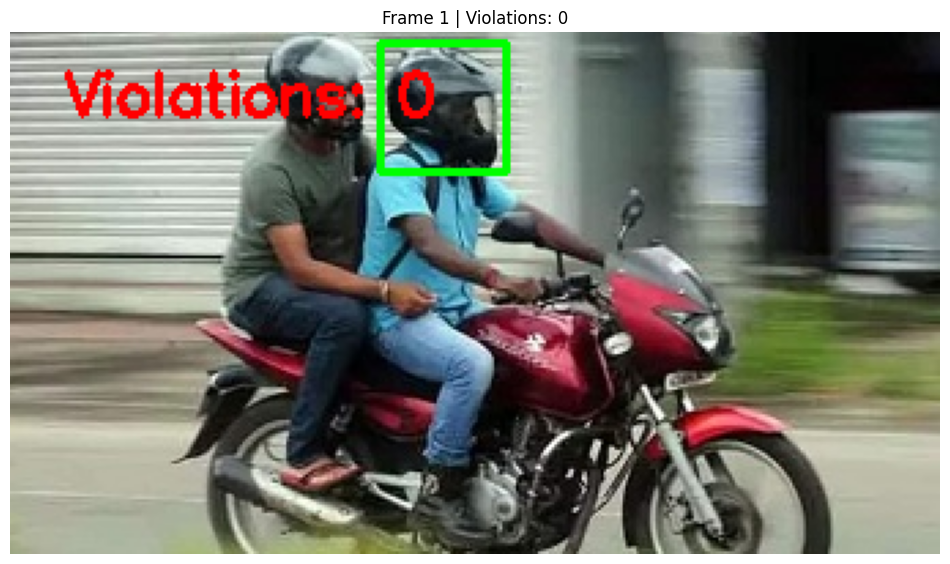


0: 384x640 1 With Helmet, 12.7ms
Speed: 3.0ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)


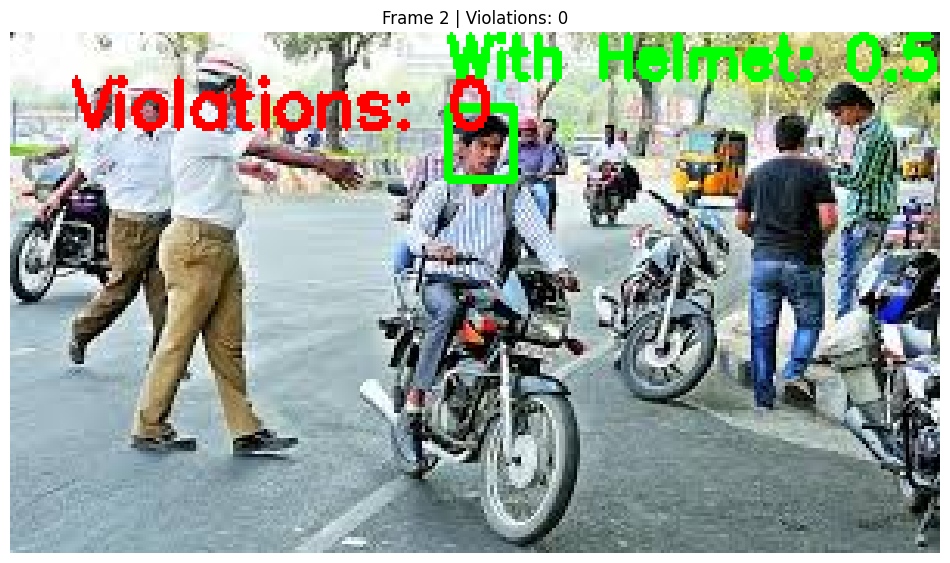


0: 480x640 1 Without Helmet, 12.3ms
Speed: 3.1ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


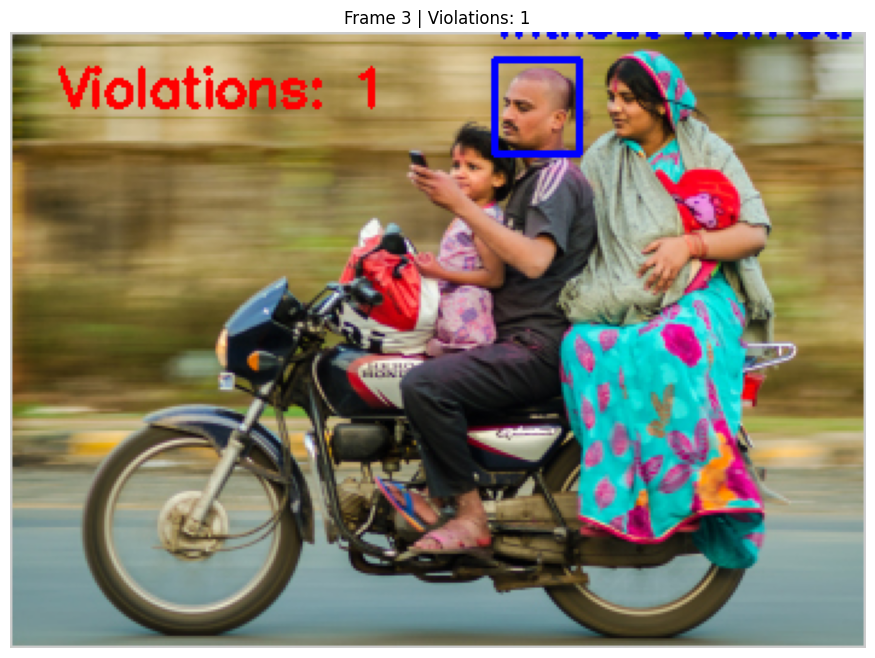


0: 384x640 2 Without Helmets, 12.0ms
Speed: 3.3ms preprocess, 12.0ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)


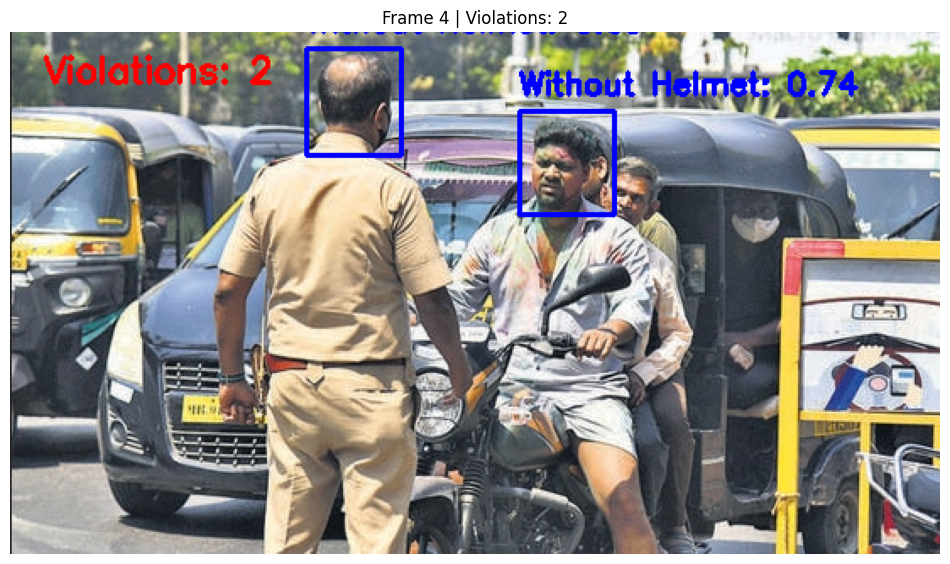


0: 384x640 2 With Helmets, 1 Without Helmet, 10.5ms
Speed: 2.5ms preprocess, 10.5ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


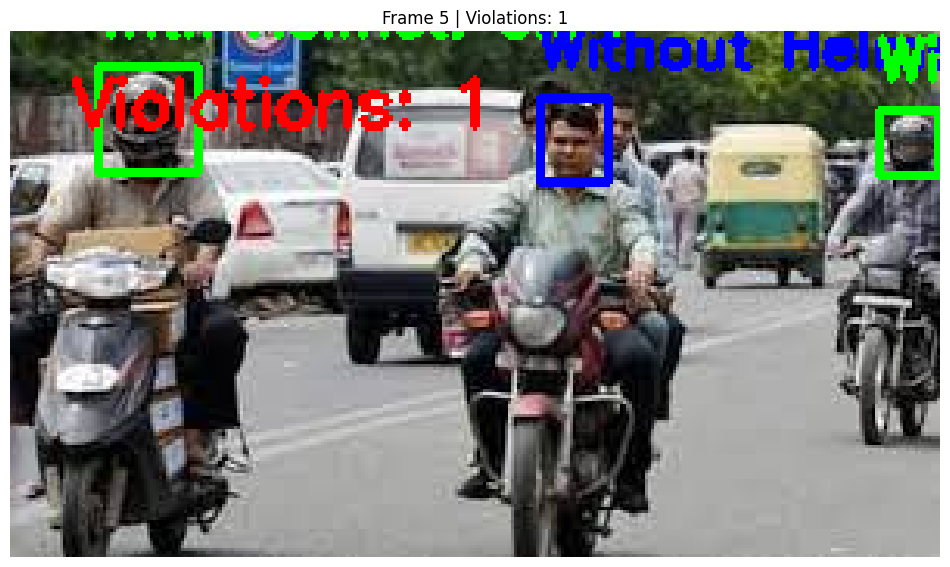


0: 448x640 2 With Helmets, 1 Without Helmet, 11.3ms
Speed: 2.2ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


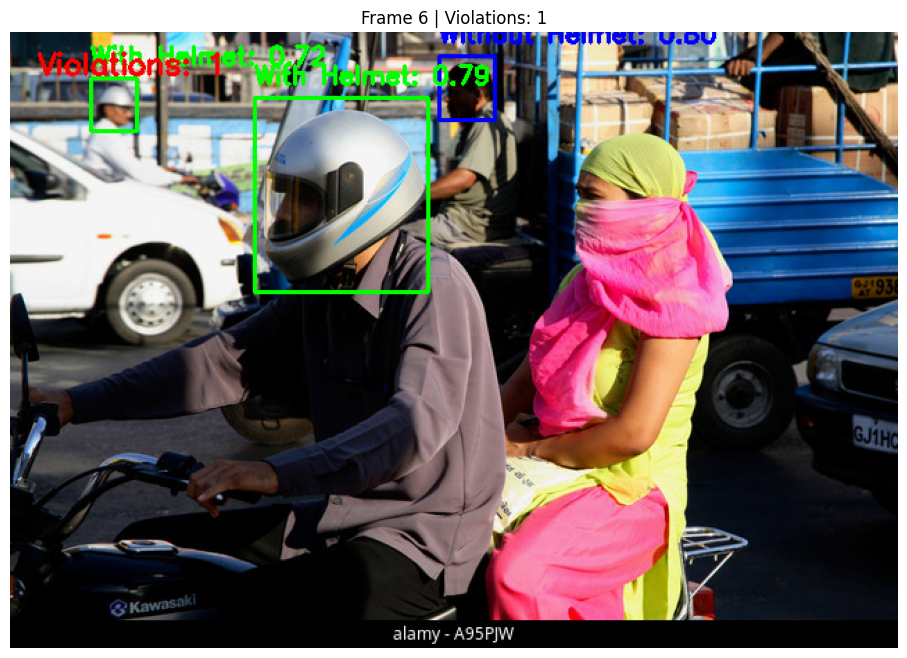


0: 320x640 1 With Helmet, 62.7ms
Speed: 2.2ms preprocess, 62.7ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


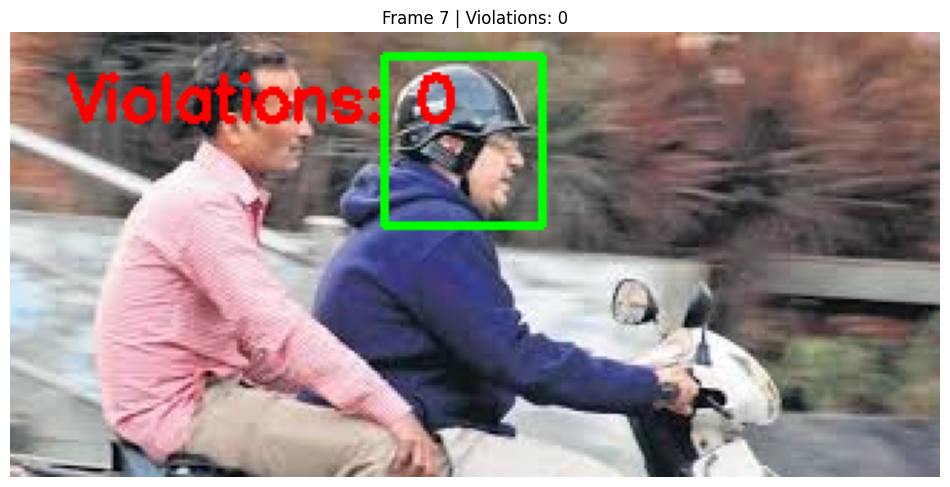


0: 512x640 1 With Helmet, 1 Without Helmet, 58.0ms
Speed: 3.2ms preprocess, 58.0ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


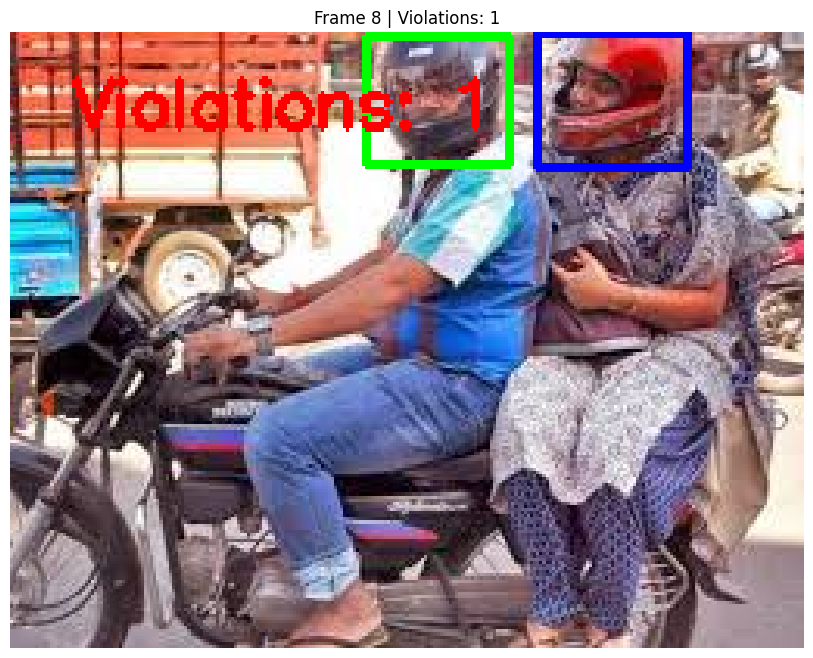


0: 448x640 1 With Helmet, 12.1ms
Speed: 3.1ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)


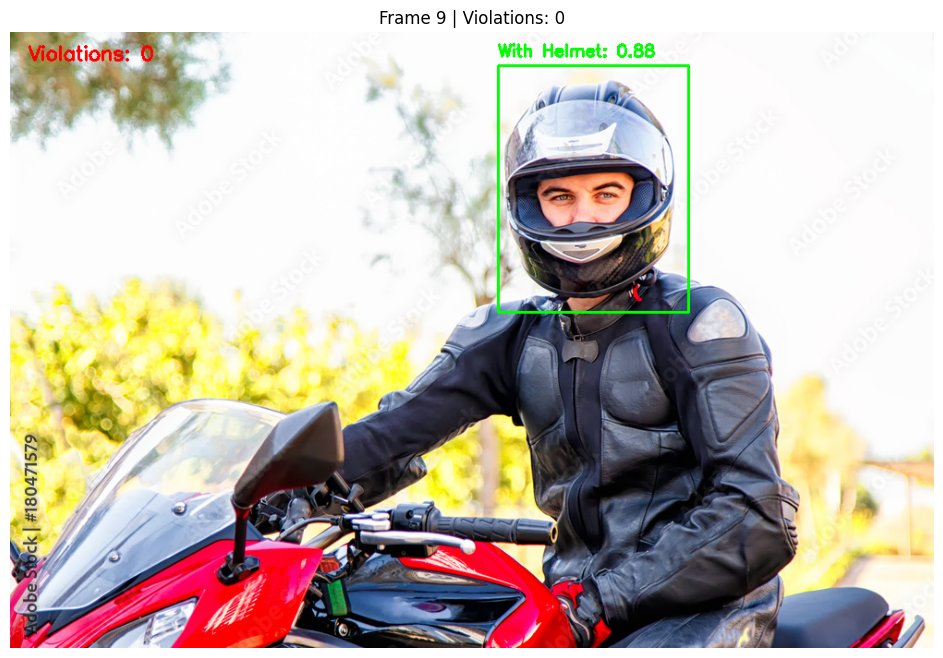


=== VIOLATION SUMMARY ===
Total violations detected: 6

=== DETAILED LOG ===


frame           class  confidence                 bbox
0      1     With Helmet    0.832409    (135, 4, 181, 51)
0      2     With Helmet    0.525888   (141, 24, 162, 47)
0      3  Without Helmet    0.614235   (200, 11, 235, 50)
0      4  Without Helmet    0.740424  (301, 47, 357, 108)
1      4  Without Helmet    0.686436   (175, 10, 231, 73)
0      5     With Helmet    0.844312     (28, 11, 60, 45)
1      5  Without Helmet    0.833116   (170, 21, 192, 48)
2      5     With Helmet    0.819573   (279, 25, 298, 46)
0      6  Without Helmet    0.797103   (309, 17, 349, 63)
1      6     With Helmet    0.794591  (176, 47, 301, 187)
2      6     With Helmet    0.719384     (58, 33, 91, 71)
0      7     With Helmet    0.864121    (130, 8, 185, 67)
0      8     With Helmet    0.774345    (114, 1, 160, 42)
1      8  Without Helmet    0.725981    (169, 0, 217, 43)
0      9     With Helmet    0.882616  (528, 36, 734, 303)


Log saved to: /content/test_results/violation_log.csv


In [ ]:
test_model()